In [26]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
import tensorflow as tf
import os
import random

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def get_all_filenames(directory):
    filenames = []
    directory = "./hand_photos/" + directory
    list_dir = os.listdir(directory)
    list_dir = [f.lower() for f in list_dir]
    list_dir = sorted(list_dir)
    for file in list_dir:
        filenames.append(file)
    
    return filenames


"""
WE MIGHT HAVE THE PROBLEM OF THESE BEING NUMPY ARRAYS WHEN WE PUT IT INTO JAVASCRIPT 
IF THIS IS AN ISSUE THEN WE SHOULD JUST CHANGE IT BACK TO AN NORMAL ARRAY RIGHT BEFORE 
IT GETS TURNED INTO A TENSOR
"""
def get_pixel_arrays(directory, images, value):
    pixels = []
    pixels.append(value)
    for image in images:
        image = "./hand_photos/" + directory + "/" + image
        im = Image.open(image, 'r')
        im = im.resize((240,240),Image.ANTIALIAS)
        pix_val = list(im.getdata())
        new_arr = np.expand_dims(pix_val, 0)
        new_arr = np.asarray(new_arr).squeeze()
        #new_arr = new_arr.reshape((240, 240, 3))
        new_arr = new_arr.astype(float) / 255
        
        corr_sized = np.zeros((240,240,3))
        new_arr = new_arr.T
        for i in range(3):
            corr_sized[:,:,i] = new_arr[i].reshape((240,240))
        
        tensor = tf.convert_to_tensor(corr_sized)#, dtype=tf.float32)
        pixels.append(tensor)
    return pixels
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
left_files = get_all_filenames("left")
right_files = get_all_filenames("right")
middle_files = get_all_filenames("middle")
top_files = get_all_filenames("top")
bottom_files = get_all_filenames("bottom")
none_files = get_all_filenames("no_hand")

left_pixels = get_pixel_arrays("left", left_files, '0')
top_pixels = get_pixel_arrays("top", top_files, '1')
right_pixels = get_pixel_arrays("right", right_files, '2')
bottom_pixels = get_pixel_arrays("bottom", bottom_files, '3')
middle_pixels = get_pixel_arrays("middle", middle_files, '9')
none_pixels = get_pixel_arrays("no_hand", none_files, '4')

#only really care about 0-3
total_len = len(left_pixels) + len(right_pixels) + len(top_pixels) + len(bottom_pixels)
train_len = (total_len / 4) * 3

all_images = []
all_labels = []
for image in left_pixels:
    all_images.append(image)
    all_labels.append(0)
for image in top_pixels:
    all_images.append(image)
    all_labels.append(1)
for image in right_pixels:
    all_images.append(image)
    all_labels.append(2)
for image in bottom_pixels:
    all_images.append(image)
    all_labels.append(3)

train_images = []
train_labels = []
used_indices = []
while len(train_images) < train_len:
    index = random.randint(0, len(all_images) - 1)
    if (index in used_indices):
        continue
    train_images.append(all_images[index])
    train_labels.append(all_labels[index])
    used_indices.append(index)

test_images = []
test_labels = []
available_indices = []
for i in range(0, len(all_images)):
    if i not in used_indices:
        available_indices.append(i)
for j in available_indices:
    test_images.append(all_images[j])
    test_labels.append(all_labels[j])
    

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
# Normalize pixel values to be between 0 and 1
#print (train_images)
#train_images, test_images = train_images / 255.0, test_images / 255.0

TypeError: Image data of dtype <U1 cannot be converted to float

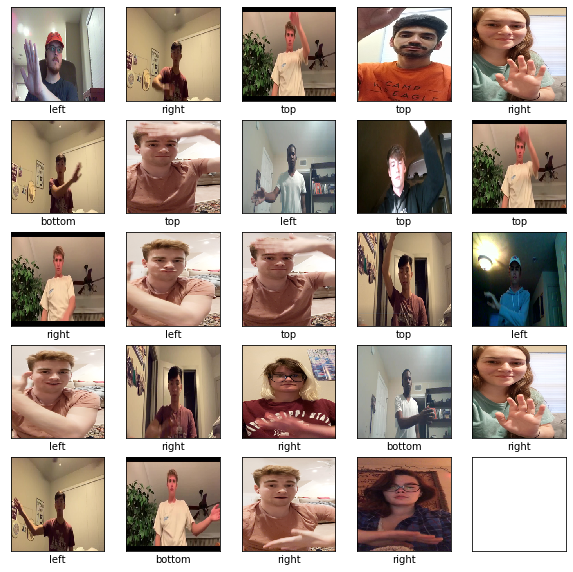

In [28]:
class_names = ['bottom', 'top', 'left', 'right']

#print(train_images).eval

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [5]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 42s 27ms/step - loss: 1.5192 - accuracy: 0.4462 - val_loss: 1.2315 - val_accuracy: 0.5627
Epoch 2/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.1361 - accuracy: 0.5973 - val_loss: 1.0441 - val_accuracy: 0.6322
Epoch 3/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.9779 - accuracy: 0.6575 - val_loss: 0.9618 - val_accuracy: 0.6677
Epoch 4/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.8897 - accuracy: 0.6885 - val_loss: 0.9023 - val_accuracy: 0.6874
Epoch 5/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.8291 - accuracy: 0.7103 - val_loss: 0.8584 - val_accuracy: 0.7048
Epoch 6/10
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7756 - accuracy: 0.7294 - val_loss: 0.8779 - val_accuracy: 0.7004
Epoch 7/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7308 - accuracy: 0.7423 - val_loss: 0.8746 -

313/313 - 2s - loss: 0.8796 - accuracy: 0.7086
0.7085999846458435


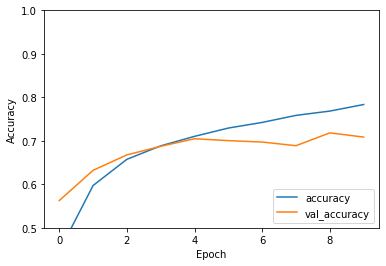

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)